In [3]:
from training import brax_stuff

from brax import envs
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import model

import jax
from jax import numpy as jp

import mujoco

import mediapy as media

import functools
from datetime import datetime

from matplotlib import pyplot as plt

import numpy as np

/home/mishmish/Documents/go_by_vibes/vibes/lib/python3.10/site-packages/mujoco/mjx/_src/device.py:108: UserWarning: Solver mjSOL_NEWTON is not supported, reverting to CG.
  warnings.warn(f'Solver {name} is not supported, reverting to CG.')


In [4]:
env = envs.get_environment("finger")

train_fn = functools.partial(
    ppo.train,
    num_timesteps=30_000, # 30_000_000,
    num_evals=5,
    reward_scaling=0.1,
    episode_length=500,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=10,
    num_minibatches=32,
    num_updates_per_batch=8,
    discounting=0.99,
    learning_rate=3e-4,
    entropy_cost=1e-2,
    num_envs=2048,
    batch_size=1024,
    seed=0,
)

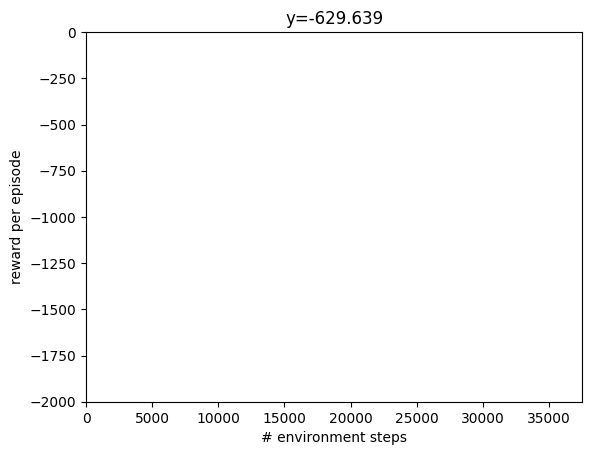

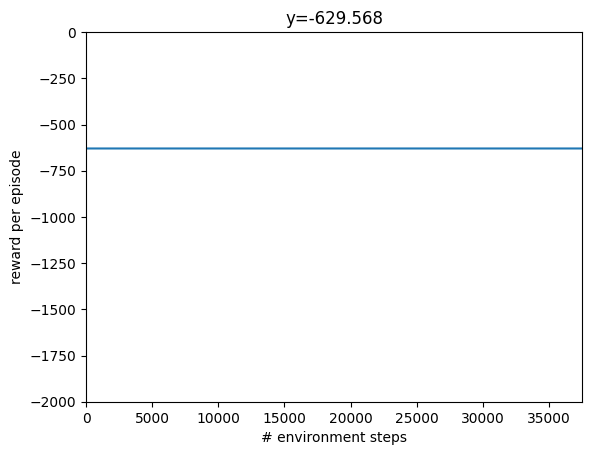

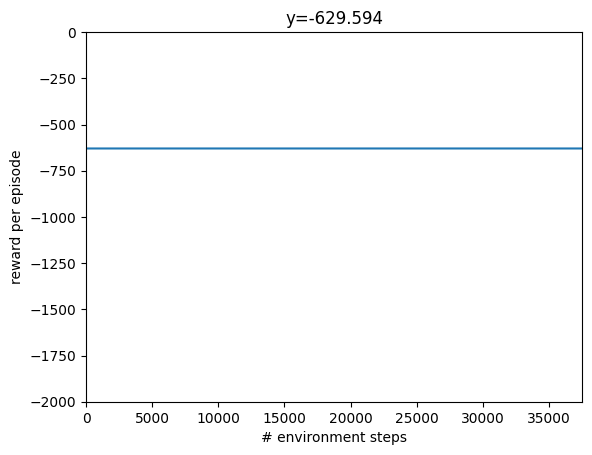

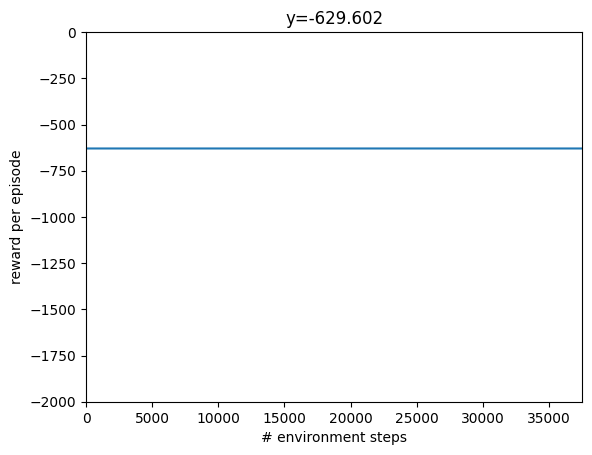

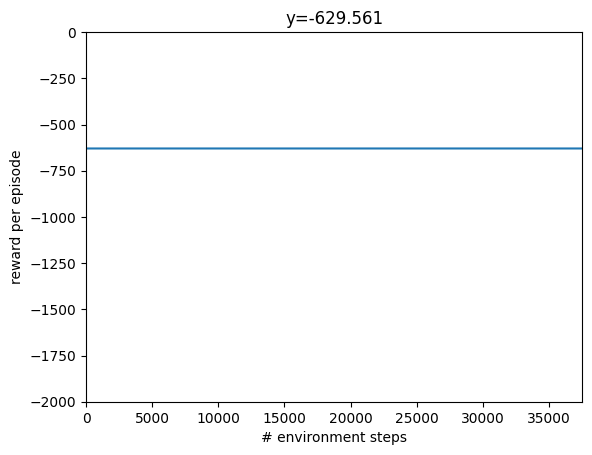

time to jit: 0:00:36.439802
time to train: 0:03:12.029365


In [ ]:
x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 0, -2000

def progress(num_steps, metrics):
    times.append(datetime.now())
    x_data.append(num_steps)
    y_data.append(metrics["eval/episode_reward"])
    ydataerr.append(metrics["eval/episode_reward_std"])

    plt.xlim([0, train_fn.keywords["num_timesteps"] * 1.25])
    plt.ylim([min_y, max_y])

    plt.xlabel("# environment steps")
    plt.ylabel("reward per episode")
    plt.title(f"y={y_data[-1]:.3f}")

    plt.errorbar(x_data, y_data, yerr=ydataerr)
    plt.show()
    

make_inference_fn, params, _= train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [ ]:
model_path = 'brax_policy/mjx_brax_policy'
model.save_params(model_path, params)

NameError: name 'model' is not defined

In [ ]:
inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

NameError: name 'make_inference_fn' is not defined

In [ ]:
eval_env = envs.get_environment('finger')

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

In [ ]:
from finger import Finger
import mujoco

rng = jax.random.PRNGKey(0)

obs = Finger.init()
ctrl = jp.zeros(2)

images = []
def scanf(obs, rng):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(obs, act_rng)

  obs = Finger.step(obs, ctrl)
  
  return obs, obs

_, states = jax.lax.scan(scanf, obs, jax.random.split(rng, 500))
video = Finger.host_make_video(states, Finger.get_config())

video = np.transpose(video, (0, 2, 3, 1))

states shape: (500, 6)


In [ ]:
media.show_video(video, fps=24)